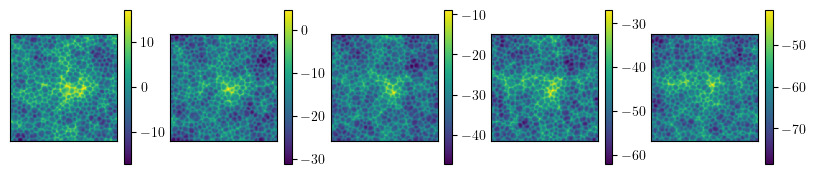

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import sys; sys.path.append("..")
import torch
from model import ELM2D
from wrapper import KS2DModelWrapper
import numpy as np

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

torch.set_grad_enabled(False)
torch.manual_seed(10)

d = torch.tensor(np.load("ks2d_long.npy"))
fig, ax = plt.subplots(1,5,figsize=(10,2))
for k in range(5):
    im = ax[k].matshow(d[k*d.shape[0]//5,:,:].numpy())
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    plt.colorbar(im)
plt.show()

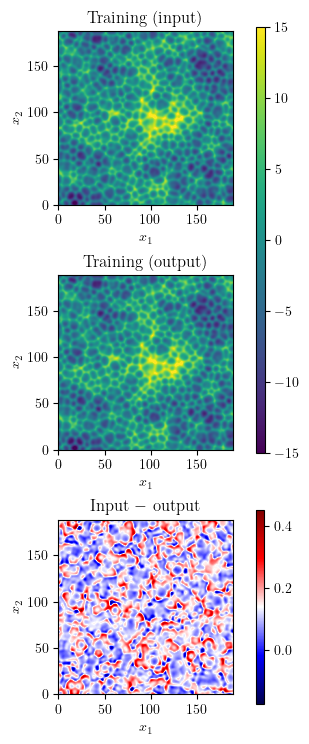

In [6]:
%matplotlib inline
d = torch.tensor(np.load("ks2d_short.npy"))
pred_skips = 5
d = d[::pred_skips,:,:] # dt = 0.01, so if we skip 5, then the ELM learns in steps of 0.05 time units.

extent = 2
step = 4
hidden = 600
L = 60*torch.pi
model = KS2DModelWrapper(ELM2D((extent,extent),(step,step),hidden))

N0, N1 = d.shape[1:]
X = d[0,None,:,:]
Y = d[1,None,:,:]

model.train(X, Y, nr_symmetries=1, stopping_threshold=1e-3, noise=1e-4)
# plt.hist(model.model.lout.weight.data.flatten())
# plt.show()

fig, ax = plt.subplots(3, 1, figsize=(3,9))
im1 = ax[0].imshow(X[0].cpu(), vmin=-15, vmax=15, extent=[0,L,0,L])
im2 = ax[1].imshow(Y[0].cpu(), vmin=-15, vmax=15, extent=[0,L,0,L])
im3 = ax[2].imshow((X[0] - Y[0]).cpu(), cmap="seismic", extent=[0,L,0,L])

ax[0].set_xlabel("$x_1$")
ax[1].set_xlabel("$x_1$")
ax[2].set_xlabel("$x_1$")

ax[0].set_ylabel("$x_2$")
ax[1].set_ylabel("$x_2$")
ax[2].set_ylabel("$x_2$")
ax[0].set_title("Training (input)")
ax[1].set_title("Training (output)")
ax[2].set_title("Input $-$ output")

plt.colorbar(im1,ax=ax[:2], shrink=0.95, aspect=46, pad=0.1)
plt.colorbar(im3,ax=ax[2], shrink=0.95, aspect=23, pad=0.1)
plt.savefig("plots/ks2d_training.pdf", format="pdf", bbox_inches="tight")
plt.show()

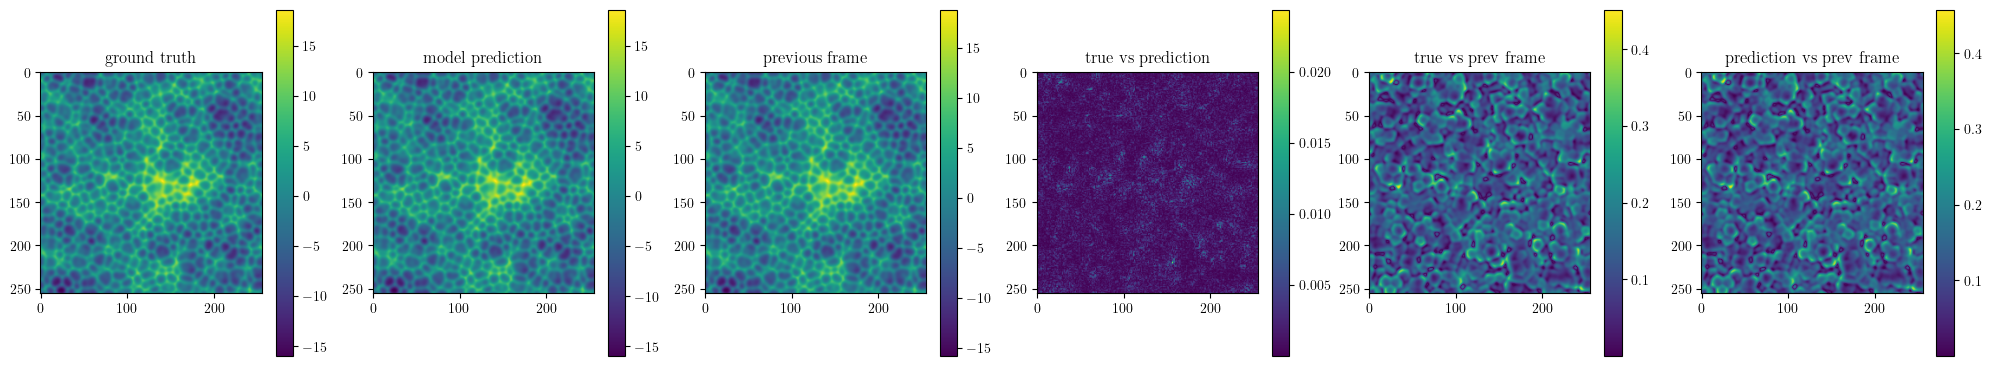

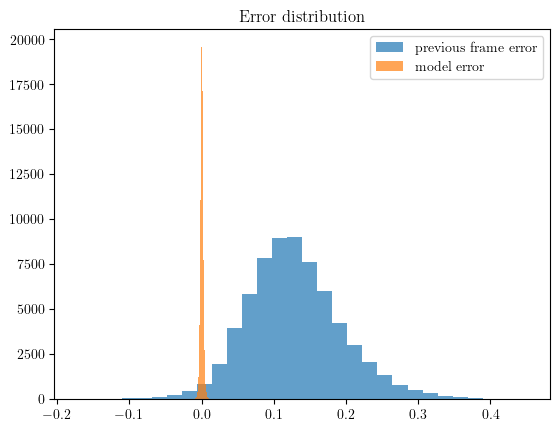

In [7]:
X_test = d[-2,...]
Y_test = d[-1,...]
Y_pred = model(X_test)

fig, ax = plt.subplots(1,6,figsize=(25,15))
plt.colorbar(ax[0].imshow(Y_test),shrink=0.3)
ax[0].set_title("ground truth")
plt.colorbar(ax[1].imshow(Y_pred),shrink=0.3)
ax[1].set_title("model prediction")
plt.colorbar(ax[2].imshow(X_test),shrink=0.3)
ax[2].set_title("previous frame")

model_error = Y_pred - Y_test
plt.colorbar(ax[3].imshow(model_error.abs()),shrink=0.3)
ax[3].set_title("true vs prediction")
prev_error = X_test - Y_test
plt.colorbar(ax[4].imshow(prev_error.abs()),shrink=0.3)
ax[4].set_title("true vs prev frame")

model_error_prev = Y_pred - X_test
plt.colorbar(ax[5].imshow(model_error_prev.abs()),shrink=0.3)
ax[5].set_title("prediction vs prev frame")
plt.show()

plt.hist(prev_error.flatten(), bins=30, label="previous frame error", alpha=0.7)
plt.hist(model_error.flatten(), bins=30, label="model error", alpha=0.7)
plt.title("Error distribution")
plt.legend()
plt.show()

In [9]:
from tqdm import tqdm

d = torch.tensor(np.load("ks2d_long.npy"))
d_pred = torch.empty(*d.shape)
T = d[0,...].clone()
for j in tqdm(range(d.shape[0])):
    d_pred[j,...] = T
    for _ in range(50 // pred_skips): # 0.5s
        T = model(T)

100%|██████████| 60/60 [00:15<00:00,  3.94it/s]


<>:38: SyntaxWarning: invalid escape sequence '\%'
<>:38: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_1710609/2260972214.py:38: SyntaxWarning: invalid escape sequence '\%'
  ax[2][i].text(30*torch.pi,-75,f"RSE = ${rse.mean():.2f}\%$",rotation="horizontal",horizontalalignment="center", verticalalignment="center")


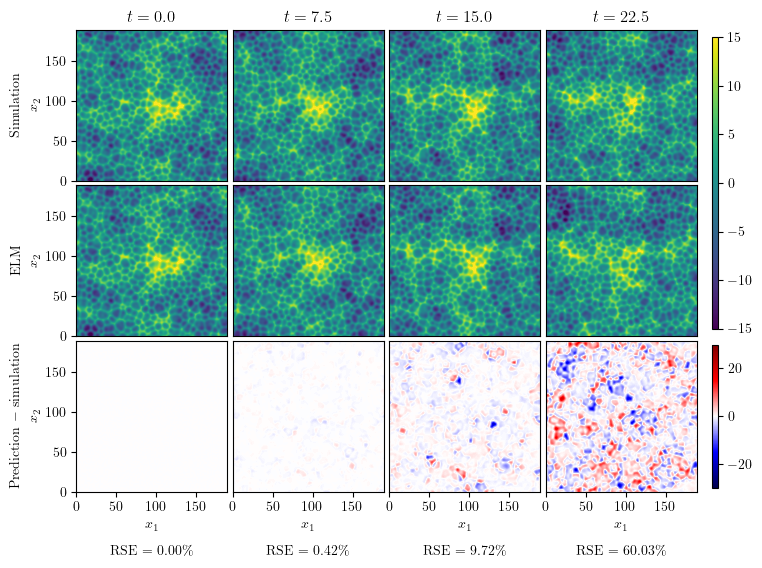

In [10]:
plt_step = 15

fig, ax = plt.subplots(3, d.shape[0] // plt_step, 
                       figsize=(10,6), gridspec_kw={"wspace":-.1,"hspace":.03})
ext = [0,60*torch.pi,0,60*torch.pi]
for i in range(d.shape[0] // plt_step):
    average = d[i*plt_step,...].mean()

    im1 = ax[0][i].imshow(
        ( d[i*plt_step,...] - average )
        .numpy(),vmax=15,vmin=-15,extent=ext)
    im2 = ax[1][i].imshow(
        ( d_pred[i*plt_step,...] - average )
        .numpy(),vmax=15,vmin=-15,extent=ext)
    if i > 0:
        ax[0][i].set_yticks([])
        ax[1][i].set_yticks([])
        ax[2][i].set_yticks([])
    ax[0][0].yaxis.set_major_locator(plt.MultipleLocator(50))
    ax[1][0].yaxis.set_major_locator(plt.MultipleLocator(50))
    ax[2][0].yaxis.set_major_locator(plt.MultipleLocator(50))
    ax[0][0].set_ylabel("$x_2$")
    ax[1][0].set_ylabel("$x_2$")
    ax[2][0].set_ylabel("$x_2$")
    ax[0][i].set_xticks([])
    ax[1][i].set_xticks([])
    ax[2][i].xaxis.set_major_locator(plt.MultipleLocator(50))
    ax[2][i].set_xlabel("$x_1$")

    t = 0.5 * i * plt_step
    residual = d_pred[i*plt_step,...] - d[i*plt_step,...]
    rse = 100 * residual.pow(2) / (d[i*plt_step,...] - average).pow(2).mean()

    # im3 = ax[2][i].imshow(rse.numpy(),cmap="OrRd",extent=ext,norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=10000))
    im3 = ax[2][i].imshow(residual.numpy(),cmap="seismic",extent=ext,vmin=-30, vmax=30)

    ax[0][i].set_title(f"$t = {t:.1f}$")
    ax[2][i].text(30*torch.pi,-75,f"RSE = ${rse.mean():.2f}\%$",rotation="horizontal",horizontalalignment="center", verticalalignment="center")

ax[0][0].text(-75,30*torch.pi,"Simulation",rotation="vertical",horizontalalignment="center", verticalalignment="center")
ax[1][0].text(-75,30*torch.pi,"ELM",rotation="vertical",horizontalalignment="center", verticalalignment="center")
ax[2][0].text(-75,30*torch.pi,"Prediction $-$ simulation",rotation="vertical",horizontalalignment="center", verticalalignment="center")

plt.colorbar(im1, ax=[ax[i][j] for i in range(2) for j in range(d.shape[0] // plt_step)], shrink=0.95, pad=0.02, aspect=46)
plt.colorbar(im3, ax=[ax[2][j] for j in range(d.shape[0] // plt_step)], shrink=0.95, pad=0.02, aspect=23)

plt.savefig("plots/ks2d.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
# enjoy a nice animation
# import itertools
# %matplotlib qt
# torch.set_grad_enabled(False)
# d = next(iter(Dataset("ks2d_long.npy")))
# T = d[0,...][None,...]
# 
# im = plt.matshow(T[0,...].numpy(), vmin=0, vmax=1)
# model_fast= model.to(torch.float32).to("cuda")
# T_fast = T.to(torch.float32).to("cuda")
# energy = T_fast.mean()
# for j in itertools.count():
#     T_fast = model_fast(T_fast)
#     T_fast = energy + T_fast - T_fast.mean()
#     if j % 10 == 0:
#         im.set_data(T_fast[0,...].cpu())
#         plt.pause(0.000001)
#         plt.draw()